In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory
from pprint import pprint
import spacy
import numpy as np

In [117]:
class Config:
    SEED: int = 42
    SAMPLE: int = 10000
    BASE_DATA_PATH: str = '../data/'
    BASE_OUTPUT_PATH: str = '../output/'

In [3]:
file_path = f'{Config.BASE_DATA_PATH}/arXiv_scientific dataset.csv'

raw_df = pd.read_csv(file_path)

In [4]:
raw_df.describe()

summary_word_count
count       136238.000000
mean           162.386830
std             49.374474
min              1.000000
25%            128.000000
50%            160.000000
75%            195.000000
max            552.000000

In [5]:
raw_df.head()

id                                              title  \
0  cs-9308101v1                               Dynamic Backtracking   
1  cs-9308102v1  A Market-Oriented Programming Environment and ...   
2  cs-9309101v1            An Empirical Analysis of Search in GSAT   
3  cs-9311101v1  The Difficulties of Learning Logic Programs wi...   
4  cs-9311102v1  Software Agents: Completing Patterns and Const...   

                  category category_code published_date updated_date  \
0  Artificial Intelligence         cs.AI         8/1/93       8/1/93   
1  Artificial Intelligence         cs.AI         8/1/93       8/1/93   
2  Artificial Intelligence         cs.AI         9/1/93       9/1/93   
3  Artificial Intelligence         cs.AI        11/1/93      11/1/93   
4  Artificial Intelligence         cs.AI        11/1/93      11/1/93   

                                          authors       first_author  \
0                              ['M. L. Ginsberg']   'M. L. Ginsberg'   
1                               ['M. P. Wellman']    'M. P. Wellman'   
2                      ['I. P. Gent', 'T. Walsh']       'I. P. Gent'   
3  ['F. Bergadano', 'D. Gunetti', 'U. Trinchero']     'F. Bergadano'   
4            ['J. C. Schlimmer', 'L. A. Hermens']  'J. C. Schlimmer'   

                                             summary  summary_word_count  
0  Because of their occasional need to return to ...                  79  
1  Market price systems constitute a well-underst...                 119  
2  We describe an extensive study of search in GS...                 167  
3  As real logic programmers normally use cut (!)...                 174  
4  To support the goal of allowing users to recor...                 187

In [6]:
raw_df['category'].value_counts()

category
Machine Learning                                          39986
Computer Vision and Pattern Recognition                   29057
Computation and Language (Natural Language Processing)    25202
Artificial Intelligence                                   12969
Machine Learning (Statistics)                             10447
                                                          ...  
Nuclear Experiment                                            1
Superconductivity                                             1
Pattern Formation and Solitons                                1
General Mathematics                                           1
History and Philosophy of Physics                             1
Name: count, Length: 138, dtype: int64

In [7]:
raw_df['summary'][10]

'We report on a series of experiments in which all decision trees consistent\nwith the training data are constructed. These experiments were run to gain an\nunderstanding of the properties of the set of consistent decision trees and the\nfactors that affect the accuracy of individual trees. In particular, we\ninvestigated the relationship between the size of a decision tree consistent\nwith some training data and the accuracy of the tree on test data. The\nexperiments were performed on a massively parallel Maspar computer. The results\nof the experiments on several artificial and two real world problems indicate\nthat, for many of the problems investigated, smaller consistent decision trees\nare on average less accurate than the average accuracy of slightly larger\ntrees.'

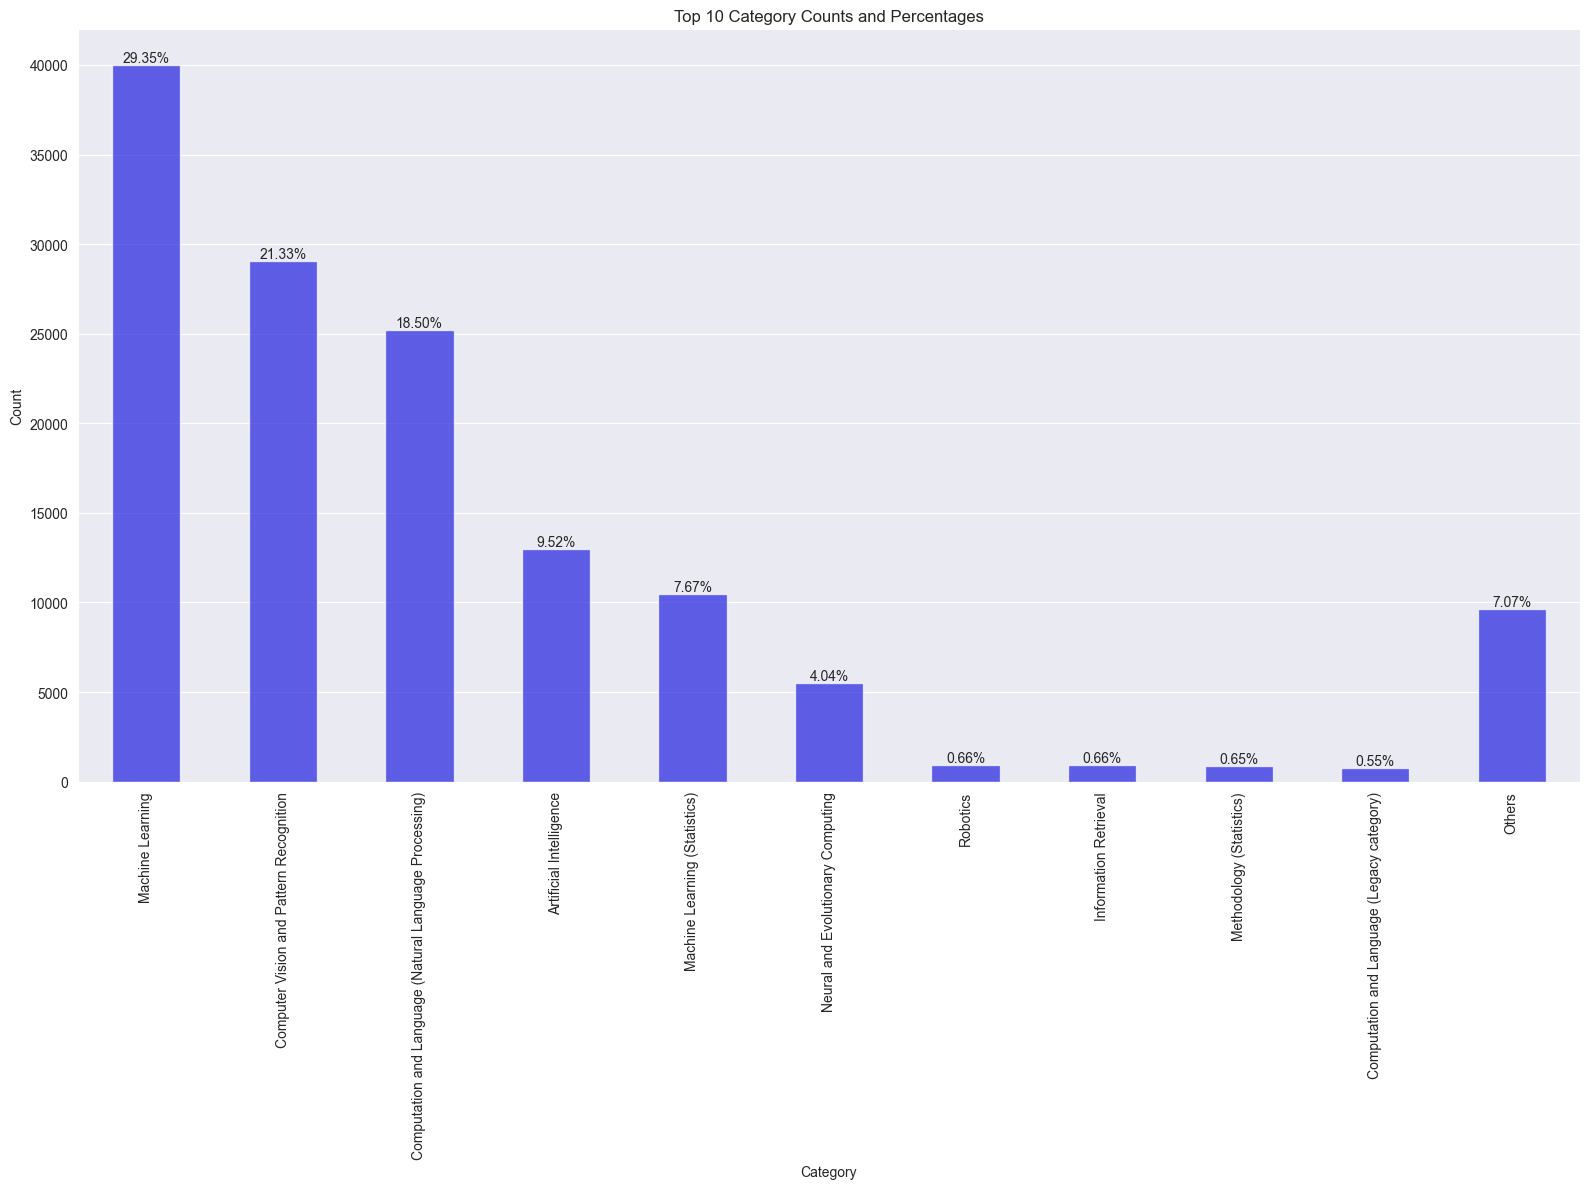

In [8]:
# Calculate the counts of the categories
category_counts = raw_df['category'].value_counts()

# Select the top 10 categories and group the rest into 'Others'
top_categories = category_counts.head(10)
other_categories = category_counts.iloc[10:].sum()


# Create a new category that includes 'Others'
category_counts_modified = pd.concat([top_categories, pd.Series({'Others': other_categories})])
# Calculate the percentages
category_percentages = category_counts_modified / category_counts_modified.sum() * 100

# Combine counts and percentages into a DataFrame
category_df = pd.DataFrame({
    'count': category_counts_modified,
    'percentage': category_percentages
}).reset_index()
category_df.columns = ['category', 'count', 'percentage']

# Create a Seaborn bar plot
plt.figure(figsize=(16, 12))
sns.barplot(x='category', y='count', data=category_df, color='blue', alpha=0.7, width=0.5)

# Annotate percentages on top of bars
for i in range(len(category_df)):
    plt.text(i, category_df['count'].iloc[i] + 0.5, f'{category_df["percentage"].iloc[i]:.2f}%', 
             ha='center', va='bottom', fontsize=10)

plt.title('Top 10 Category Counts and Percentages')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [9]:
df = raw_df.sample(Config.SAMPLE, random_state=Config.SEED)
del raw_df

In [10]:
df.isnull().values.any()

np.False_

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 78358 to 58556
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  10000 non-null  object
 1   title               10000 non-null  object
 2   category            10000 non-null  object
 3   category_code       10000 non-null  object
 4   published_date      10000 non-null  object
 5   updated_date        10000 non-null  object
 6   authors             10000 non-null  object
 7   first_author        10000 non-null  object
 8   summary             10000 non-null  object
 9   summary_word_count  10000 non-null  int64 
dtypes: int64(1), object(9)
memory usage: 859.4+ KB


In [12]:
DetectorFactory.seed = Config.SEED

languages = []

# go through each text
for ii in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['summary'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

100%|██████████| 10000/10000 [00:21<00:00, 470.94it/s]


In [13]:
languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 10000

{'en': 10000}


In [14]:
print(f'In summary, there are {languages_dict}')

In summary, there are {'en': 10000}


/var/folders/m_/m2qplsqx2p760zbv9t6sqyj40000gn/T/ipykernel_59884/1152327472.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  published_date = pd.to_datetime(df['published_date'])


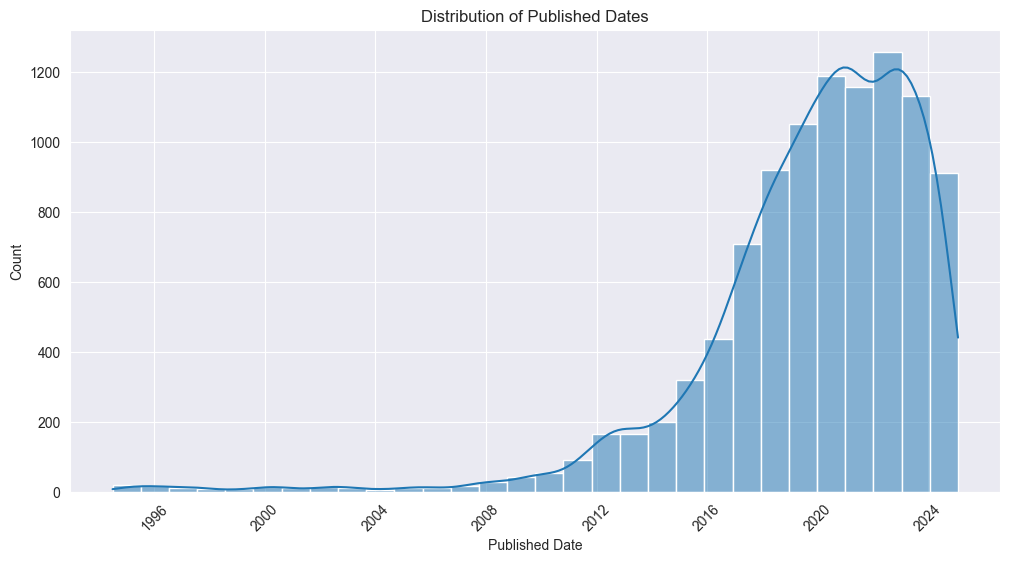

In [15]:
published_date = pd.to_datetime(df['published_date'])

plt.figure(figsize=(12, 6))
sns.histplot(published_date, bins=30, kde=True)  # Adjust bins as needed
plt.xticks(rotation=45)
plt.xlabel("Published Date")
plt.ylabel("Count")
plt.title("Distribution of Published Dates")
plt.show()

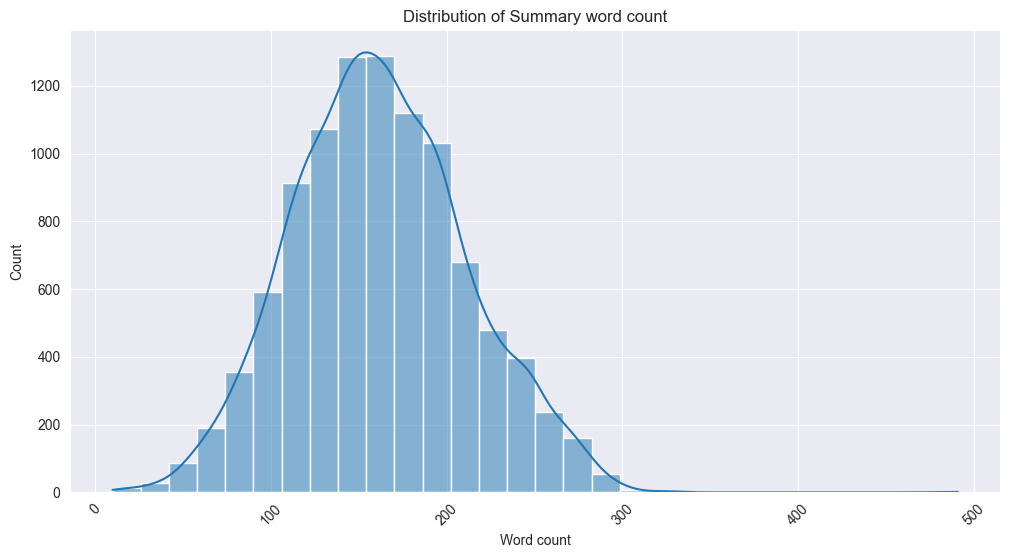

In [16]:
plt.figure(figsize=(12, 6))
sns.histplot(df['summary_word_count'], bins=30, kde=True)  # Adjust bins as needed
plt.xticks(rotation=45)
plt.xlabel("Word count")
plt.ylabel("Count")
plt.title("Distribution of Summary word count")
plt.show()

In [69]:
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm

stopwords = list(STOP_WORDS)
print(f'{len(stopwords)=}')
print(f'{stopwords[:10]=}')
punctuations = string.punctuation

len(stopwords)=326
stopwords[:10]=['itself', 'one', 'via', 'namely', 'give', 'so', 'put', 'out', 'noone', 'keep']


In [70]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

In [71]:
parser = en_core_web_sm.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens


In [73]:
parser = en_core_web_sm.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [74]:
df.head()

id  \
78358   abs-1704.04688v1   
37291   abs-2405.16697v1   
132977  abs-2109.03754v2   
69011   abs-2102.07318v4   
57403   abs-1812.05788v2   

                                                                                                title  \
78358                                                      Machine Learning and the Future of Realism   
37291    CNN Autoencoder Resizer: A Power-Efficient LoS/NLoS Detector in\n  MIMO-enabled UAV Networks   
132977  Memory and Knowledge Augmented Language Models for Inferring Salience in\n  Long-Form Stories   
69011                   A Global to Local Double Embedding Method for Multi-person Pose\n  Estimation   
57403               AU R-CNN: Encoding Expert Prior Knowledge into R-CNN for Action Unit\n  Detection   

                                                      category category_code  \
78358                            Machine Learning (Statistics)       stat.ML   
37291                                         Machine Learning         cs.LG   
132977  Computation and Language (Natural Language Processing)         cs.CL   
69011                  Computer Vision and Pattern Recognition         cs.CV   
57403                  Computer Vision and Pattern Recognition         cs.CV   

       published_date updated_date  \
78358         4/15/17      4/15/17   
37291         5/26/24      5/26/24   
132977         9/8/21      9/14/21   
69011         2/15/21     10/17/21   
57403        12/14/18      8/25/19   

                                                                                             authors  \
78358                                                               ['Giles Hooker', 'Cliff Hooker']   
37291   ['Azim Akhtarshenas', 'Navid Ayoobi', 'David Lopez-Perez', 'Ramin Toosi', 'Matin Amoozadeh']   
132977                                                              ['David Wilmot', 'Frank Keller']   
69011                         ['Yiming Xu', 'Jiaxin Li', 'Yiheng Peng', 'Yan Ding', 'Hua-Liang Wei']   
57403                                                          ['Chen Ma', 'Li Chen', 'Junhai Yong']   

               first_author  \
78358        'Giles Hooker'   
37291   'Azim Akhtarshenas'   
132977       'David Wilmot'   
69011           'Yiming Xu'   
57403             'Chen Ma'   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [75]:
tqdm.pandas()
df["processed_text"] = df["summary"].progress_apply(spacy_tokenizer)

  0%|          | 0/10000 [00:00<?, ?it/s]/Users/waritboonmasiri/Library/Caches/pypoetry/virtualenvs/nlp-research-clustering-W6zAjQxv-py3.11/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████| 10000/10000 [03:04<00:00, 54.27it/s]


In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [77]:
text = df['processed_text'].values
X = vectorize(text, 2 ** 12)
X.shape

(10000, 4096)

In [78]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(10000, 2830)

In [79]:
print(f'Reduced dimensions from {X.shape} to {X_reduced.shape}')

Reduced dimensions from (10000, 4096) to (10000, 2830)


## Clustering

In [85]:
from sklearn.cluster import KMeans

from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(2, 50)
for k in K:
    # k_means = KMeans(n_clusters=k, random_state=42, n_jobs=-1).fit(X_reduced) #TODO no n_jobs param
    k_means = KMeans(n_clusters=k, random_state=Config.SEED).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

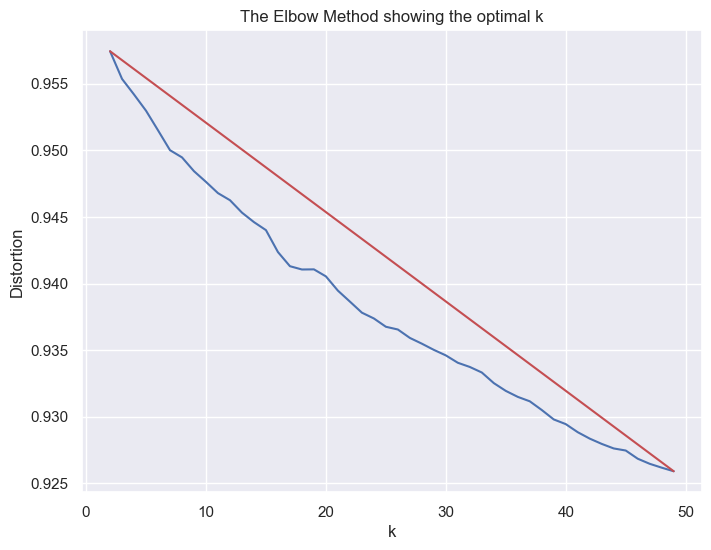

In [88]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.figure(figsize=(8, 6))
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [89]:
k = 20
kmeans = KMeans(n_clusters=k, random_state=Config.SEED)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred

In [90]:
df.head(1)

id                                       title  \
78358  abs-1704.04688v1  Machine Learning and the Future of Realism   

                            category category_code published_date  \
78358  Machine Learning (Statistics)       stat.ML        4/15/17   

      updated_date                           authors    first_author  \
78358      4/15/17  ['Giles Hooker', 'Cliff Hooker']  'Giles Hooker'   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         summary  \
78358  The preceding three decades have seen the emergence, rise, and proliferation\nof machine learning (ML). From half-recognised beginnings in perceptrons,\nneural nets, and decision trees, algorithms that extract correlations (that is,\npatterns) from a set of data points have broken free from their origin in\ncomputational cognition to embrace all forms of problem solving, from voice\nrecognition to medical diagnosis to automated scientific research and\ndriverless cars, and it is now widely opined that the real industrial\nrevolution lies less in mobile phone and similar than in the maturation and\nuniversal application of ML. Among the consequences just might be the triumph\nof anti-realism over realism.   

       summary_word_count  y  \
78358                 106  1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       processed_text  
78358  preceding decades seen emergence rise proliferation machine learning ml half recognised beginnings perceptrons neural nets decision trees algorithms extract correlations patterns set data points broken free origin computational cognition embrace forms problem solving voice recognition medical diagnosis automated scientific research driverless cars widely opined real industrial revolution lies mobile phone similar maturation universal application ml consequences triumph anti realism realism

### Dimensionality Reduction with t-SNE

In [91]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=Config.SEED)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.008s...
[t-SNE] Computed neighbors for 10000 samples in 3.788s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.302268
[t-SNE] KL divergence after 50 iterations with early exaggeration: 83.055847
[t-SNE] KL divergence after 1000 iterations: 2.675351


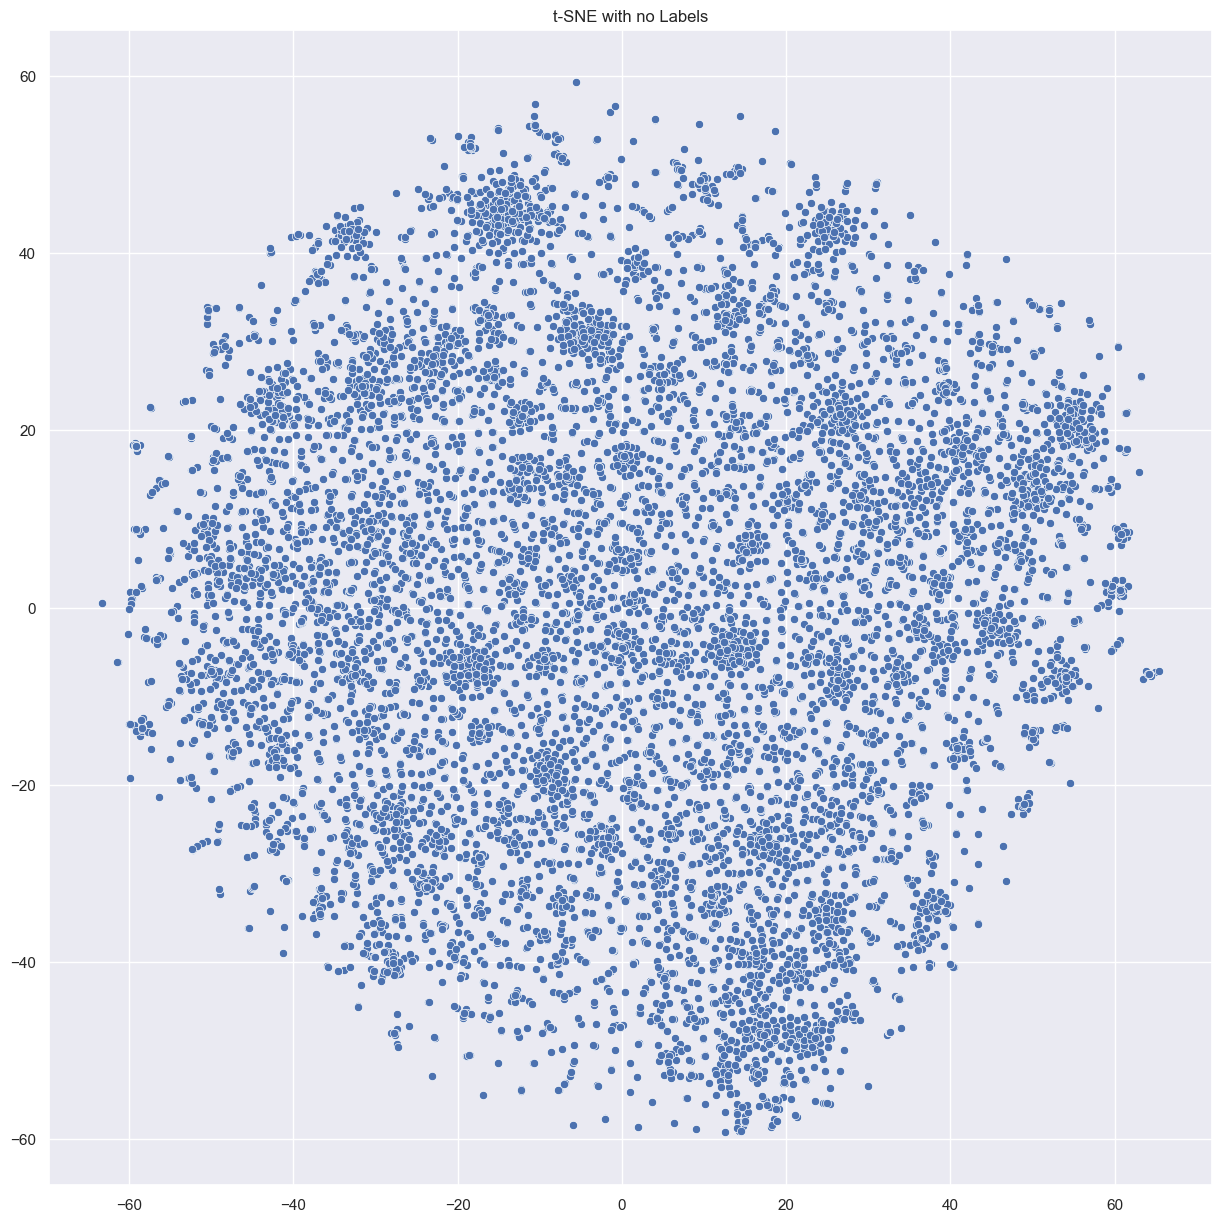

In [94]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# plot
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1])
plt.title('t-SNE with no Labels')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'plots/improved_cluster_tsne.png'

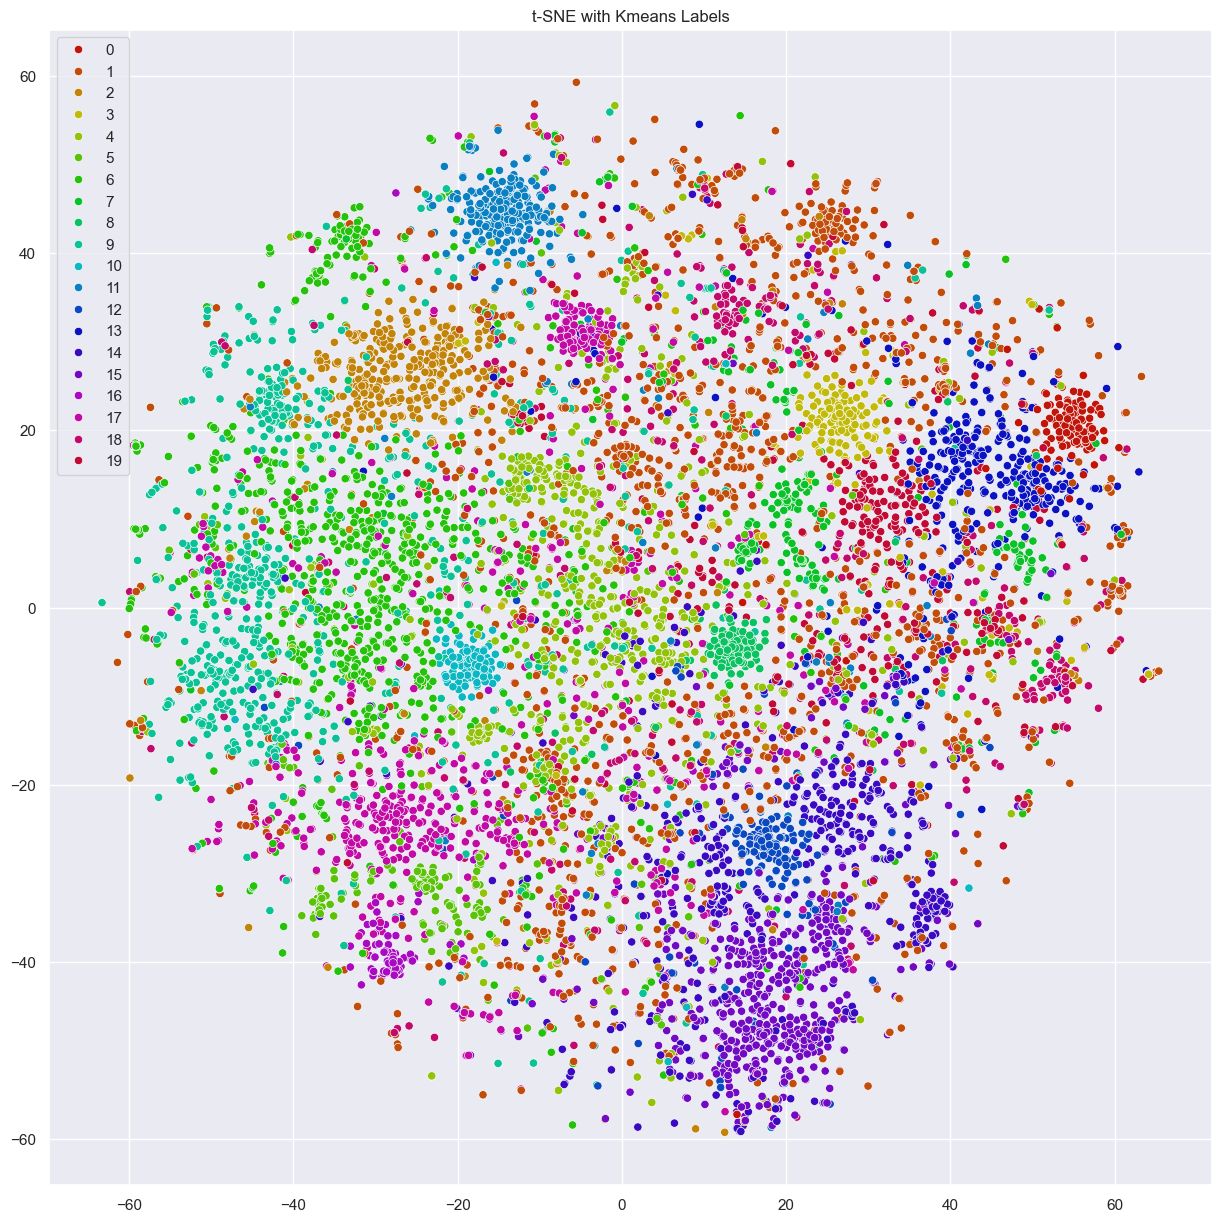

In [95]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15, 15)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.show()

In [97]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

vectorizers = []
    
for ii in range(0, 20):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

In [99]:
vectorizers[0]

CountVectorizer(max_df=0.9, min_df=5, stop_words='english',
                token_pattern='[a-zA-Z\\-][a-zA-Z\\-]{2,}')

In [100]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'processed_text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

In [101]:
len(vectorized_data)

20

In [102]:
NUM_TOPICS_PER_CLUSTER = 20

lda_models = []
for ii in range(0, 20):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(learning_method='online', n_components=20,
                          random_state=42, verbose=False)

In [104]:
clusters_lda_data = []

for current_cluster, lda in tqdm(enumerate(lda_models)):
    if vectorized_data[current_cluster] is not None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

20it [00:12,  1.58it/s]


In [109]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names_out()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for keyword in keywords:
        return_values.append(keyword[0])
    return return_values

In [110]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] is not None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

In [114]:
all_keywords[0][:10]

['nmt',
 'machine',
 'data',
 'models',
 'based',
 'languages',
 'semantic',
 'model',
 'input',
 'level']

In [127]:
for i, kws in enumerate(all_keywords):
    print(f'Cluster {i + 1}: {kws[:8]}')

Cluster 1: ['nmt', 'machine', 'data', 'models', 'based', 'languages', 'semantic', 'model']
Cluster 2: ['model', 'data', 'information', 'based', 'learning', 'models', 'time', 'attention']
Cluster 3: ['agent', 'tasks', 'policy', 'based', 'offline', 'gradient', 'feedback', 'language']
Cluster 4: ['tasks', 'reasoning', 'knowledge', 'performance', 'model', 'health', 'clinical', 'data']
Cluster 5: ['training', 'model', 'time', 'methods', 'detection', 'ood', 'classes', 'anomaly']
Cluster 6: ['training', 'pruning', 'quantization', 'hardware', 'memory', 'neural', 'networks', 'cnn']
Cluster 7: ['models', 'data', 'causal', 'matrix', 'based', 'regression', 'time', 'model']
Cluster 8: ['model', 'relations', 'student', 'relation', 'extraction', 'ner', 'entities', 'entity']
Cluster 9: ['target', 'source', 'adaptation', 'data', 'models', 'domains', 'real', 'shot']
Cluster 10: ['learning', 'optimization', 'search', 'regret', 'algorithms', 'gradient', 'bandit', 'multi']
Cluster 11: ['data', 'model', 'cl

In [118]:
import pickle

# save the final t-SNE
pickle.dump(X_embedded, open(f"{Config.BASE_OUTPUT_PATH}/X_embedded.p", "wb" ))

# save the labels generate with k-means(20)
pickle.dump(y_pred, open(f"{Config.BASE_OUTPUT_PATH}/y_pred.p", "wb" ))

In [129]:
df_research = df
topics = all_keywords
y_labels = y_pred

In [131]:
df_research.head(2)

id  \
78358  abs-1704.04688v1   
37291  abs-2405.16697v1   

                                                                                              title  \
78358                                                    Machine Learning and the Future of Realism   
37291  CNN Autoencoder Resizer: A Power-Efficient LoS/NLoS Detector in\n  MIMO-enabled UAV Networks   

                            category category_code published_date  \
78358  Machine Learning (Statistics)       stat.ML        4/15/17   
37291               Machine Learning         cs.LG        5/26/24   

      updated_date  \
78358      4/15/17   
37291      5/26/24   

                                                                                            authors  \
78358                                                              ['Giles Hooker', 'Cliff Hooker']   
37291  ['Azim Akhtarshenas', 'Navid Ayoobi', 'David Lopez-Perez', 'Ramin Toosi', 'Matin Amoozadeh']   

              first_author  \
78358       'Giles Hooker'   
37291  'Azim Akhtarshenas'   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           summary  \
78358                                                                                                                                                                                                                                                                                                    The preceding three decades have seen the emergence, rise, and proliferation\nof machine learning (ML). From half-recognised beginnings in perceptrons,\nneural nets, and decision trees, algorithms that extract correlations (that is,\npatterns) from a set of data points have broken free from their origin in\ncomputational cognition to embrace all forms of problem solving, from voice\nrecognition to medical diagnosis to automated scientific research and\ndriverless cars, and it is now widely opined that the real industrial\nrevolution lies less in mobile phone and similar than in the maturation and\nuniversal application of ML. Among the consequences just might be the triumph\nof anti-realism over realism.   
37291  Optimizing the design, performance, and resource efficiency of wireless\nnetworks (WNs) necessitates the ability to discern Line of Sight (LoS) and\nNon-Line of Sight (NLoS) scenarios across diverse applications and\nenvironments. Unmanned Aerial Vehicles (UAVs) exhibit significant potential in\nthis regard due to their rapid mobility, aerial capabilities, and payload\ncharacteristics. Particularly, UAVs can serve as vital non-terrestrial base\nstations (NTBS) in the event of terrestrial base station (TBS) failures or\ndowntime. In this paper, we propose CNN autoencoder resizer (CAR) as a\nframework that improves the accuracy of LoS/NLoS detection without demanding\nextra power consumption. Our proposed method increases the mean accuracy of\ndetecting LoS/NLoS signals from 66% to 86%, while maintaining consistent power\nconsumption levels. In addition, the resolution provided by CAR shows that it\ncan be 

In [123]:
# from plot_text import header, description, description2, cite, description_search, description_slider, notes, dataset_description, toolbox_header 
# from callbacks import input_callback, selected_code
import bokeh
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS, Slider, TapTool, TextInput
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap, transform
from bokeh.io import output_file, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import RadioButtonGroup, TextInput, Div, Paragraph
from bokeh.layouts import column, row, layout
from bokeh.layouts import column

In [177]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource

output_notebook()

hover = HoverTool(tooltips=[
    ("Title", "@titles{safe}"),
    ("Author(s)", "@authors{safe}"),
    # ("Journal", "@journal"),
    # ("Abstract", "@abstract{safe}"),
    # ("Link", "@links")
],
point_policy="follow_mouse")

mapper = linear_cmap(field_name='desc', 
                     palette=Category20[20],
                     low=min(y_labels) ,high=max(y_labels))

source = ColumnDataSource(data=dict(
    x= X_embedded[:,0], 
    y= X_embedded[:,1],
    x_backup = X_embedded[:,0],
    y_backup = X_embedded[:,1],
    desc= y_labels, 
    titles= df_research['title'],
    authors = df_research['authors'],
    # journal = df_covid['journal'],
    # abstract = df_covid['abstract_summary'],
    labels = ["C-" + str(x) for x in y_labels],
    # links = df_covid['doi']
    ))

p = figure(
    width=1200, height=850, 
    background_fill_color="white",   # the inside of the plot
    tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset', 'save', 'tap'], 
    title="AI Research clustering")
p.sizing_mode = "scale_both"
p.margin = 5

p.scatter('x','y', 
          source=source, 
          fill_color=mapper,
          line_alpha=0.3,
          line_color="black",
          size=5)
show(p)

Loading BokehJS ...